### Practice18b_Transfer_learning
Based on Chapter 14 from Aurelien Geron's book, Hands-on Machine Learning with Scikit-Learn Keras & Tensorflow.\

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/dtrad/geoml_course/blob/master/Practice18b_Transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
####################################

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

2022-11-17 15:01:45.570944: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 15:01:46.759810: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10237 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:09:00.0, compute capability: 8.6
2022-11-17 15:01:46.760468: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 5830 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:05:00.0, compute capability: 7.5


Load the tf_flowers dataset from the tf datasets library.\
Load a xception network from tf.keras.applications  and transfer learning to classify the flowers in only 5 types.\
Check the quality of the prediction for a batch by plotting the flower and printing in the title the true label and the predicted label\
Then train the new output layer and see if there is any improvement on the prediction

HINT:
You have to rewrite the output layer from the xception network, that originally outputs 1000 classes.
In this example we only need to output 5).\



In [2]:
import tensorflow_datasets as tfds
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

2022-11-17 15:02:08.282113: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10237 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:09:00.0, compute capability: 8.6
2022-11-17 15:02:08.282679: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 5830 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:05:00.0, compute capability: 7.5


In [4]:
dataset?

Type:        dict
String form: {'train': <PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>}
Length:      1
Docstring:  
dict() -> new empty dictionary
dict(mapping) -> new dictionary initialized from a mapping object's
    (key, value) pairs
dict(iterable) -> new dictionary initialized as if via:
    d = {}
    for k, v in iterable:
        d[k] = v
dict(**kwargs) -> new dictionary initialized with the name=value pairs
    in the keyword argument list.  For example:  dict(one=1, two=2)


In [5]:
info.splits["train"]

<SplitInfo num_examples=3670, num_shards=2>

In [6]:
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples
print(class_names)
print(n_classes)
print(dataset_size)

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
5
3670


Let us split the dataset as usual in testing, validation and training.

In [7]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

We will need to preprocess the images. All functions are given below.

2022-11-17 15:03:01.790613: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-17 15:03:03.291084: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


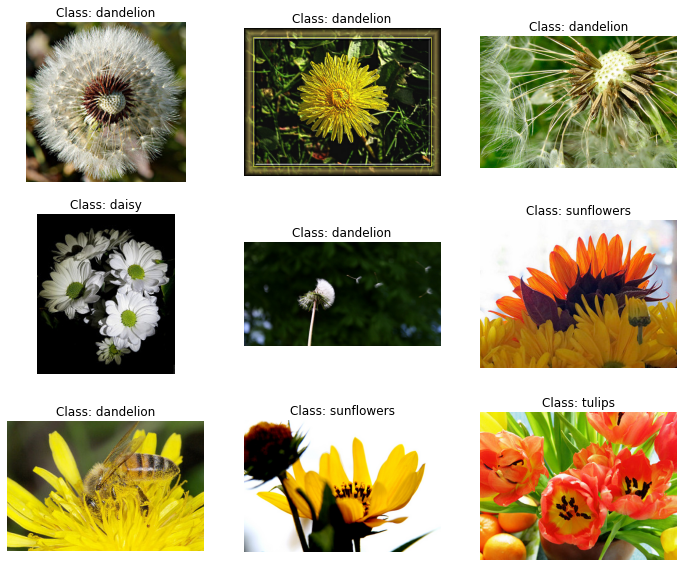

In [8]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [9]:
@tf.autograph.experimental.do_not_convert
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

@tf.autograph.experimental.do_not_convert
def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)    
    return final_image, label
from functools import partial
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

We will use a dataset class in TF that produces a batches on demand

In [10]:
train_set?

Type:           PrefetchDataset
String form:    <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>
File:           ~/anaconda3/envs/tfgpu4/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py
Docstring:      A `Dataset` that asynchronously prefetches its input.
Init docstring:
See `Dataset.prefetch()` for details.

Args:
  input_dataset: The input dataset.
  buffer_size: See `Dataset.prefetch()` for details.
  slack_period: (Optional.) An integer. If non-zero, determines the number
    of GetNext calls before injecting slack into the execution. This may
    reduce CPU contention at the start of a step. Note that a tensorflow
    user should not have to set this manually; enable this behavior
    automatically via `tf.data.Options.experimental_slack` instead. Defaults
    to None.


2022-11-17 15:03:18.010364: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


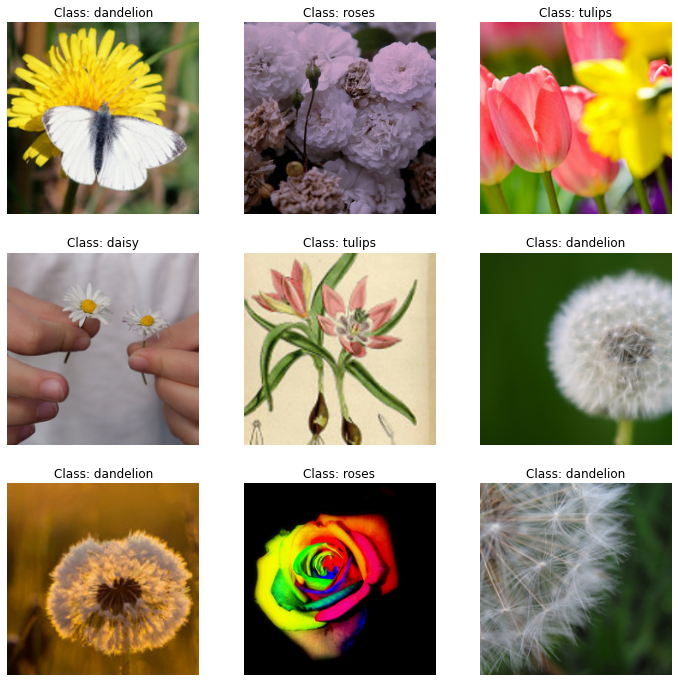

In [11]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

Next we will load an xception network without the output layer. Feel free to experiment with other networks (for example resnet)

In [12]:
#base_model = keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False)
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)

In [13]:
#base_model.summary()

We have eliminated the last two layers (GlobalAveragePooling2D() and the output to 1000 classes.\
Before predicting we will add our own GlobalAveragePooling2D and a dense layer to classify in 5 outputs (multiclass) using softmax.\
Notice the syntaxis using functional API: 

In [14]:
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)


In [15]:
#base_model.summary()

We have a very large number of parameters and layers.

In [16]:
for index, layer in enumerate(model.layers):
    if (index%10 == 0):
        print(index, layer.name)
print(index, layer.name)

0 input_1
10 block2_sepconv2
20 block3_sepconv2
30 block4_sepconv2
40 block5_sepconv2
50 block6_sepconv2
60 block7_sepconv2
70 block8_sepconv2
80 block9_sepconv2
90 block10_sepconv2
100 block11_sepconv2
110 block12_sepconv2
120 block13_sepconv2
130 block14_sepconv2_bn
133 dense


In [25]:
for index, layer in enumerate(base_model.layers):
    if (index%10 == 0):
        print(index, layer.name)
print(index, layer.name)

0 input_1
10 block2_sepconv2
20 block3_sepconv2
30 block4_sepconv2
40 block5_sepconv2
50 block6_sepconv2
60 block7_sepconv2
70 block8_sepconv2
80 block9_sepconv2
90 block10_sepconv2
100 block11_sepconv2
110 block12_sepconv2
120 block13_sepconv2
130 block14_sepconv2_bn
131 block14_sepconv2_act


Before start training, which will be slow, let us try to understand the inputs and outputs
Let us take one batch, predict, and compare with labels.

In [26]:
print(X_batch.shape)
print(y_batch.shape)
for i in range(5):
    print(class_names[y_batch[i]])

(32, 224, 224, 3)
(32,)
dandelion
roses
tulips
daisy
tulips


In [27]:
y_pred=model.predict(X_batch)

In [28]:
print(y_batch)

tf.Tensor([0 4 2 1 2 0 0 4 0 2 1 3 3 0 3 0 3 3 2 0 1 1 3 3 4 2 2 0 2 3 4 1], shape=(32,), dtype=int64)


The y_pred output is not the class itself but the probability of each of the 5 classes

In [29]:
print(y_pred.shape)
print(y_pred[:,:])

(32, 5)
[[0.26705807 0.15689246 0.21259066 0.20851846 0.15494032]
 [0.0812012  0.27634847 0.28729758 0.20152874 0.15362404]
 [0.14259003 0.1558266  0.23073651 0.18274528 0.28810158]
 [0.2225406  0.11528328 0.24603793 0.23996766 0.17617057]
 [0.15802562 0.23606004 0.21722889 0.16132775 0.22735766]
 [0.2671398  0.08186977 0.33097586 0.20177431 0.11824024]
 [0.20018065 0.15051971 0.25221515 0.22274987 0.17433465]
 [0.31790072 0.13052778 0.24146253 0.15795432 0.15215464]
 [0.14997959 0.16830578 0.32015994 0.15185954 0.20969513]
 [0.21030915 0.16006571 0.22493826 0.19157124 0.21311568]
 [0.14691661 0.20587519 0.20752035 0.290661   0.14902684]
 [0.2319244  0.11367083 0.19559509 0.22295736 0.23585239]
 [0.1617925  0.139173   0.3508533  0.19952527 0.14865594]
 [0.1789648  0.15117444 0.32547945 0.19083387 0.15354748]
 [0.12831473 0.18323512 0.15780328 0.26486504 0.26578185]
 [0.16009739 0.14196435 0.35879543 0.14755535 0.19158748]
 [0.13331659 0.11274094 0.2795     0.18462458 0.2898179 ]
 [0.22

In [30]:
# Get the corresponding class by finding the maximum probability in the output
print(X_batch.shape)
print(y_batch.shape)
print(y_pred.shape)
for i in range(32):    
    ii=np.argmax(y_pred[i,:])
    print('real class:',class_names[y_batch[i]],'==>:', class_names[ii],' --> ',int(y_pred[0,ii]*100),'%')

(32, 224, 224, 3)
(32,)
(32, 5)
real class: dandelion ==>: dandelion  -->  26 %
real class: roses ==>: tulips  -->  21 %
real class: tulips ==>: roses  -->  15 %
real class: daisy ==>: tulips  -->  21 %
real class: tulips ==>: daisy  -->  15 %
real class: dandelion ==>: tulips  -->  21 %
real class: dandelion ==>: tulips  -->  21 %
real class: roses ==>: dandelion  -->  26 %
real class: dandelion ==>: tulips  -->  21 %
real class: tulips ==>: tulips  -->  21 %
real class: daisy ==>: sunflowers  -->  20 %
real class: sunflowers ==>: roses  -->  15 %
real class: sunflowers ==>: tulips  -->  21 %
real class: dandelion ==>: tulips  -->  21 %
real class: sunflowers ==>: roses  -->  15 %
real class: dandelion ==>: tulips  -->  21 %
real class: sunflowers ==>: roses  -->  15 %
real class: sunflowers ==>: tulips  -->  21 %
real class: tulips ==>: tulips  -->  21 %
real class: dandelion ==>: tulips  -->  21 %
real class: daisy ==>: roses  -->  15 %
real class: daisy ==>: tulips  -->  21 %
real 

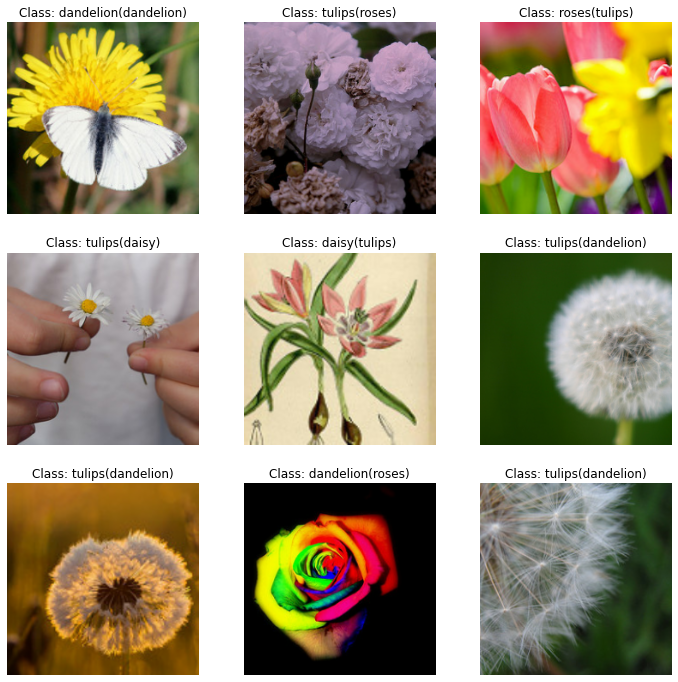

In [31]:
plt.figure(figsize=(12, 12))
for index in range(9):
    ii=np.argmax(y_pred[index,:])
    plt.subplot(3, 3, index + 1)
    plt.imshow(X_batch[index] / 2 + 0.5)    
    plt.title("Class: {}({})".format(class_names[ii],class_names[y_batch[index]]))
    plt.axis("off")

plt.show()

The prediction is quite bad but that is because we haven't trained the added layers yet.

In [32]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])


In [33]:
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 11s 98ms/step - loss: 1.5106 - accuracy: 0.7021 - val_loss: 1.0249 - val_accuracy: 0.8217
Epoch 2/5
86/86 [==============================] - 7s 83ms/step - loss: 0.5532 - accuracy: 0.8799 - val_loss: 0.9377 - val_accuracy: 0.8419
Epoch 3/5
86/86 [==============================] - 7s 84ms/step - loss: 0.4096 - accuracy: 0.9097 - val_loss: 0.7998 - val_accuracy: 0.8621
Epoch 4/5
86/86 [==============================] - 7s 84ms/step - loss: 0.2704 - accuracy: 0.9359 - val_loss: 0.7049 - val_accuracy: 0.8768
Epoch 5/5
86/86 [==============================] - 7s 84ms/step - loss: 0.1890 - accuracy: 0.9431 - val_loss: 0.6432 - val_accuracy: 0.8713


In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

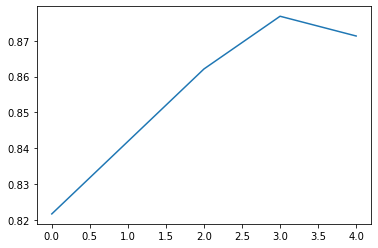

In [35]:
plt.plot(history.history['val_accuracy'])

In [36]:
y_pred2=model.predict(X_batch)

In [37]:
model.evaluate(valid_set)

18/18 [==============================] - 2s 78ms/step - loss: 0.6352 - accuracy: 0.8730


[0.6352415084838867, 0.872958242893219]

In [38]:
# Get the corresponding class by finding the maximum probability in the output
print(X_batch.shape)
print(y_batch.shape)
print(y_pred.shape)
print(y_pred2.shape)
for i in range(32):
    jj=np.argmax(y_pred[i,:])
    ii=np.argmax(y_pred2[i,:])
    print('real class:',class_names[y_batch[i]])
    print(' now    ==>:', class_names[ii],' --> ',int(y_pred2[i,ii]*100),'%')
    print(' before ==>:', class_names[jj],' --> ',int(y_pred[i,jj]*100),'%')

(32, 224, 224, 3)
(32,)
(32, 5)
(32, 5)
real class: dandelion
 now    ==>: dandelion  -->  99 %
 before ==>: dandelion  -->  26 %
real class: roses
 now    ==>: roses  -->  99 %
 before ==>: tulips  -->  28 %
real class: tulips
 now    ==>: tulips  -->  100 %
 before ==>: roses  -->  28 %
real class: daisy
 now    ==>: daisy  -->  100 %
 before ==>: tulips  -->  24 %
real class: tulips
 now    ==>: tulips  -->  99 %
 before ==>: daisy  -->  23 %
real class: dandelion
 now    ==>: dandelion  -->  100 %
 before ==>: tulips  -->  33 %
real class: dandelion
 now    ==>: dandelion  -->  67 %
 before ==>: tulips  -->  25 %
real class: roses
 now    ==>: roses  -->  99 %
 before ==>: dandelion  -->  31 %
real class: dandelion
 now    ==>: dandelion  -->  100 %
 before ==>: tulips  -->  32 %
real class: tulips
 now    ==>: tulips  -->  99 %
 before ==>: tulips  -->  22 %
real class: daisy
 now    ==>: daisy  -->  99 %
 before ==>: sunflowers  -->  29 %
real class: sunflowers
 now    ==>: sunfl

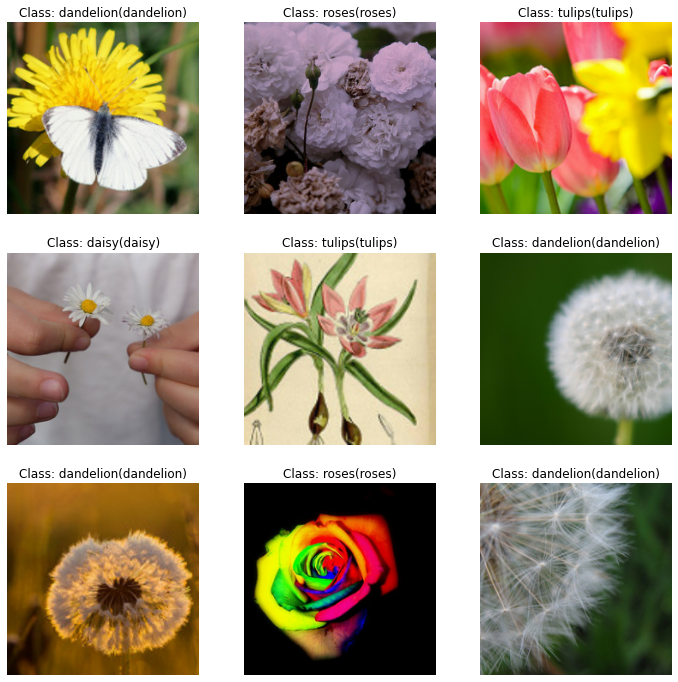

In [39]:
plt.figure(figsize=(12, 12))
for index in range(9):
        ii=np.argmax(y_pred2[index,:])
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)        
        plt.title("Class: {}({})".format(class_names[ii],class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

Final step: we fine tuning all layers. This will take long time.

In [40]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
86/86 [==============================] - 35s 354ms/step - loss: 0.4054 - accuracy: 0.8717 - val_loss: 0.5461 - val_accuracy: 0.8401
Epoch 2/40
86/86 [==============================] - 30s 347ms/step - loss: 0.1207 - accuracy: 0.9597 - val_loss: 0.3273 - val_accuracy: 0.9026
Epoch 3/40
86/86 [==============================] - 30s 348ms/step - loss: 0.0680 - accuracy: 0.9787 - val_loss: 0.2719 - val_accuracy: 0.9283
Epoch 4/40
86/86 [==============================] - 30s 348ms/step - loss: 0.0522 - accuracy: 0.9804 - val_loss: 0.2809 - val_accuracy: 0.9191
Epoch 5/40
86/86 [==============================] - 31s 362ms/step - loss: 0.0432 - accuracy: 0.9864 - val_loss: 0.2397 - val_accuracy: 0.9301
Epoch 6/40
86/86 [==============================] - 30s 350ms/step - loss: 0.0238 - accuracy: 0.9923 - val_loss: 0.2809 - val_accuracy: 0.9210
Epoch 7/40
86/86 [==============================] - 30s 350ms/step - loss: 0.0325 - accuracy: 0.9897 - val_loss: 0.3279 - val_accuracy: 0.9044

In [41]:
model.evaluate(valid_set)

18/18 [==============================] - 1s 68ms/step - loss: 0.2836 - accuracy: 0.9328


[0.2836400866508484, 0.9328493475914001]

In [42]:
model.evaluate(test_set)

12/12 [==============================] - 1s 89ms/step - loss: 0.2599 - accuracy: 0.9401


[0.25987768173217773, 0.9400544762611389]